In [1]:
import tarfile
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import textblob as tb

np.random.seed(100)

path = "C:/Users/E12473/Desktop/kaggle/yelp/prediction/"
file_name = 'Hygiene.tar.gz'

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Unzip Compressed Files

In [2]:
df = pd.DataFrame()
# open the tarfile and use the 'r:gz' parameter
# the 'r:gz' mode enables gzip compression reading
tfile = tarfile.open(path + file_name, 'r:gz')
 
# 99.9% of the time you just want to extract all
# the contents of the archive.
for item in tfile:
    tfile.extract(item, '.')
    print item.name

Hygiene
Hygiene/hygiene.dat.additional
Hygiene/hygiene.dat
Hygiene/hygiene.dat.labels


### Import Labels

In [3]:
#hygiene.dat.labels: For the first 546 lines, a binary label (0 or 1) is used where a 0 indicates that the restaurant has 
    #passed the latest public health inspection test, while a 1 means that the restaurant has failed the test. The rest of 
    #the lines have "[None]" in their label field implying that they are part of the testing subset.

df_labels = pd.read_csv('Hygiene/hygiene.dat.labels', names=['failed_ind'])

df_train_y = df_labels[df_labels.failed_ind != "[None]"]

print df_labels.shape
df_labels.head()

(13299, 1)


,failed_ind
0,1
1,1
2,1
3,0
4,0


### Import & Clean Reviews

In [4]:
def sentiment(df_text_column):
    """Function that calculates the sentiment and polarity for each review
    
    Parameters
    ----------
    df_text_column: Pandas data frame column
    """
    wiki = []
    ls_index = []
    
    for index, string in df_text_column.iteritems():
        text_blob = tb.TextBlob(str(string))
        
        wiki.append(text_blob.sentiment)
        ls_index.append(index)
        
    df_temp = pd.DataFrame(wiki, columns = ['polarity','subjectivity'], index=ls_index)
    return df_temp

In [5]:
def pos_dummies(df_text_column):
    """Function that calculates the part of speech frequencies for each review
    
    Parameters
    ----------
    df_text_column: Pandas data frame column
    """
    
    wiki = [] #To store the list of pos tags 
    ls_index = [] #To store the index
    
    # For each string
    for index, string in df_text_column.iteritems():
        text_blob = tb.TextBlob(str(string)) #Convert the string to a text blob object
        wiki.append(text_blob.tags) #Append pos tags to list
        ls_index.append(index) #Append index to list
        
    df_temp=pd.DataFrame() #Create empty dataframe
    #For each item number in list containing pos tags
    for i in range(0, len(wiki)):
        test = pd.DataFrame(wiki[i], columns=[i,'pos']) #Create a data frame from each pos item in list
        #Append the number of words for each pos tag
        df_temp = df_temp.append(test.groupby('pos').count().T)

    df_temp = df_temp.reset_index(drop=True).fillna(0)
    return df_temp

In [6]:
def tdm(df_column, tuple_ngram_range, order_by_count = True, stop_words = 'english', min_df=1, max_df=1.0):
    """Function that creates an term document matrix from a Pandas column"""
    #Creates a term frequency matrix from a text pandas dataframe column
    from sklearn.feature_extraction.text import CountVectorizer
    
    df_column = df_column.fillna(" ")
    countvec = CountVectorizer(ngram_range = tuple_ngram_range, stop_words = stop_words, min_df = min_df, max_df = max_df)

    temp_df = pd.DataFrame(countvec.fit_transform(df_column).toarray(), columns=countvec.get_feature_names(),
                           index = df_column.index)
    
    if order_by_count == True:
        ordered_columns_by_count = temp_df.sum().reset_index().sort_values(0, ascending=False)['index']
        temp_df = temp_df[ordered_columns_by_count]
    
    return temp_df

In [7]:
#hygiene.dat: Each line contains the concatenated text reviews of one restaurant.

# Open file
reviews = open('Hygiene/hygiene.dat')
data = reviews.readlines()

print data[0]

df_reviews = pd.DataFrame(data,columns=['reviews'])

#Clean the reviews
df_reviews["reviews"] = df_reviews["reviews"].str.lower().str.strip().str.replace("&#160;","").str.replace('[^\w\s]',
                        '').str.replace(' +',
                                        ' ').str.replace('"','').str.replace('\n','')

# Create a feature that determines length of the string
df_char_length = df_reviews.reviews.str.len()
df_char_length.name ="review_char_length"

# Create a feature that determines number of words in a review
df_num_words = df_reviews.reviews.apply(lambda x: len(x.split()))
df_num_words.name = 'review_num_words'

print df_reviews.shape
print df_reviews.reviews[0]
df_reviews.head()

The baguettes and rolls are excellent, and although I haven't tried them yet I'm excited about the dozen-plus types of filled croissants on offer at ridiculously low prices. &#160;Cheese, with or without ham? &#160;Blueberry, with or without cream cheese? &#160;Chocolate, almond? &#160;This could be dangerous. &#160;I have a bad bakery habit, but at least at Q Bakery I won't go broke while I get fat. &#160;I've tried four different banh mi, and I'll agree with Matthew that the basic ones are somewhat Americanized. &#160;Mushroom was more interesting than chicken or BBQ pork, obviously. &#160;That made this a good place to get food for the in-laws that seemed exotic, but not too scary. &#160;(Note to self: don't publish this on Facebook, where the in-laws might see it.) &#160; Q Bakery's location on two divided streets makes it a slight pain to get to, but it's worth a stop if you want affordable variety. This used to be the location of my favorite Bahn Mi shop in Seattle, King Baguette

,reviews
0,the baguettes and rolls are excellent and alth...
1,i live up the street from betty when my sister...
2,im worried about how i will review this place ...
3,why cant you access them on google street view...
4,things to like about this place homemade guaca...


In [8]:
# Get pos dummy variables
%time df_pos = pos_dummies(df_reviews.reviews)
df_pos.head()

Wall time: 5min 26s


,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,...,VBD,VBG,VBG|NN,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,30,5,64,6,4,90,53,7,1,3,...,26,11,0,15,19,17,1,0,0,4
1,96,20,228,2,0,244,202,5,3,21,...,134,25,0,54,39,54,9,7,0,14
2,103,18,190,3,3,208,168,18,5,31,...,118,21,0,43,51,40,6,6,0,14
3,243,50,537,14,6,573,474,18,26,55,...,349,60,0,102,99,106,19,12,0,20
4,34,9,83,2,2,108,78,6,3,9,...,40,7,0,23,27,20,1,3,0,2


In [9]:
# Get sentiment for each verbatim
%time df_sentiment = sentiment(df_reviews.reviews)
df_sentiment.head()

Wall time: 2min 7s


,polarity,subjectivity
0,0.160625,0.578656
1,0.182132,0.623393
2,0.149712,0.563289
3,0.261486,0.568099
4,0.195297,0.550908


In [10]:
# Create term document matrix
%time df_tdm = tdm(df_reviews.reviews, (1,3), stop_words='english', min_df=20)
print df_tdm.shape
df_tdm.head()

Wall time: 3min 18s
(13299, 61235)


,good,food,place,like,great,just,really,service,time,dont,...,like normally,pretty good way,pretty good usually,bar tiny,sauce big,like needs,offered suggestions,friend having,pretty good staff,atmosphere quaint
0,1,2,4,4,4,1,0,1,0,4,...,0,0,0,0,0,0,0,0,0,0
1,11,14,13,9,12,6,8,8,7,5,...,0,0,0,0,0,0,0,0,0,0
2,11,22,9,6,9,9,10,9,5,7,...,0,0,0,0,0,0,0,0,0,0
3,37,40,26,19,19,16,18,20,19,9,...,0,0,0,0,0,0,0,0,0,0
4,8,11,8,2,6,4,2,8,1,2,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# from sklearn.ensemble import RandomForestClassifier
# temp_est = RandomForestClassifier(n_estimators=200).fit(df_tdm[df_labels.failed_ind != "[None]"].values, 
#                                                         df_train_y.failed_ind.values)

# from sklearn import preprocessing
# lb = preprocessing.LabelBinarizer()
# temp = np.array([number[0] for number in lb.fit_transform(df_train_y.failed_ind.values)])

# from sklearn import cross_validation
# temp_scores = cross_validation.cross_val_score(temp_est, df_tdm[df_labels.failed_ind != "[None]"].values, 
#                                                temp,
#                                                cv=3, scoring="f1", verbose=0)

# print "Term Frequency Matrix F1 mean score,", np.mean(temp_scores), np.std(temp_scores)
# #Term Frequency Matrix F1 mean score, 0.610772087796 0.0273961116464

### Import Additional Info and Clean

In [12]:
#hygiene.dat.additional: It is a CSV (Comma-Separated Values) file where the first value is a list containing the cuisines 
    #offered, the second value is the zip code, which gives an idea about the location, the third is the number of reviews, 
    #and the fourth is the average rating, which can vary between 0 and 5 (5 being the best).

#Import file
df_add = pd.read_csv('Hygiene/hygiene.dat.additional', 
                     names=['category', 'zip_code', 'num_reviews', 'average_rating'])
print df_add.shape

# Import in manually created dummy file to join
df_category = pd.read_csv(path + 'category_dummies.csv', index_col='id')
print df_category.shape

# Drop the categories and join the dummies category variables
df_add = df_add.drop('category', axis=1).join(df_category)

#Do the same for zip codes
df_add = df_add.drop('zip_code', axis=1).join(pd.get_dummies(df_add.zip_code))

df_add.head()

(13299, 4)
(13299, 168)


,num_reviews,average_rating,African,American (New),American (Traditional),Barbeque,Basque,Belgian,Brazilian,Breakfast & Brunch,...,98134,98136,98144,98146,98166,98168,98177,98178,98188,98199
0,4,4.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21,4.047619,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,3.111111,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42,4.088889,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,3.071429,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Combine All Data Souces

In [13]:
#Join all of the dataframes containing features
df = df_sentiment.join(df_num_words).join(df_char_length).join(df_add).join(df_tdm).join(df_pos)

print df.shape
df.head()

(13299, 61474)


,polarity,subjectivity,review_num_words,review_char_length,num_reviews,average_rating,African,American (New),American (Traditional),Barbeque,...,VBD,VBG,VBG|NN,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.160625,0.578656,690,3694,4,4.000000,0,0,0,0,...,26,11,0,15,19,17,1,0,0,4
1,0.182132,0.623393,2177,11662,21,4.047619,0,0,0,0,...,134,25,0,54,39,54,9,7,0,14
2,0.149712,0.563289,1935,10122,14,3.111111,0,0,0,0,...,118,21,0,43,51,40,6,6,0,14
3,0.261486,0.568099,5264,28499,42,4.088889,0,0,0,0,...,349,60,0,102,99,106,19,12,0,20
4,0.195297,0.550908,888,4636,12,3.071429,0,0,0,0,...,40,7,0,23,27,20,1,3,0,2


In [14]:
# Create new additional features
df['avg_char_length_per_review'] = df.review_char_length / df.num_reviews
df['avg_num_words_per_review'] = df.review_num_words / df.num_reviews

df['avg_char_length_per_rating'] = df.review_char_length / df.average_rating
df['avg_num_words_per_rating'] = df.review_num_words / df.average_rating

df['avg_word_length'] = df.review_char_length / df.review_num_words

df['weighted_average'] = df['num_reviews'] * df['average_rating']

df['char_length_times_subjectivity'] = df.review_char_length * df.subjectivity
df['char_length_times_polarity'] = df.review_char_length * df.polarity

df['num_words_times_subjectivity'] = df.review_num_words * df.subjectivity
df['num_words_times_polarity'] = df.review_num_words * df.polarity

df['num_reviews_times_subjectivity'] = df.num_reviews * df.subjectivity
df['num_reviews_times_polarity'] = df.num_reviews * df.polarity

df['average_rating_times_subjectivity'] = df.average_rating * df.subjectivity
df['average_rating_times_polarity'] = df.average_rating * df.polarity

In [15]:
df_train_y.shape

(546, 1)

In [16]:
df.shape

(13299, 61488)

In [17]:
#Split the data into training and testing sets
df_train = df[df_labels.failed_ind != "[None]"]
print df_train.shape
#df_train.to_csv(path + "training.csv")

df_test = df[df_labels.failed_ind =="[None]"]
print df_test.shape
#df_test.to_csv(path + "testing.csv")

(546, 61488)
(12753, 61488)


# Modeling

### Random Forest

In [21]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
temp = np.array([number[0] for number in lb.fit_transform(df_train_y.failed_ind.values)])

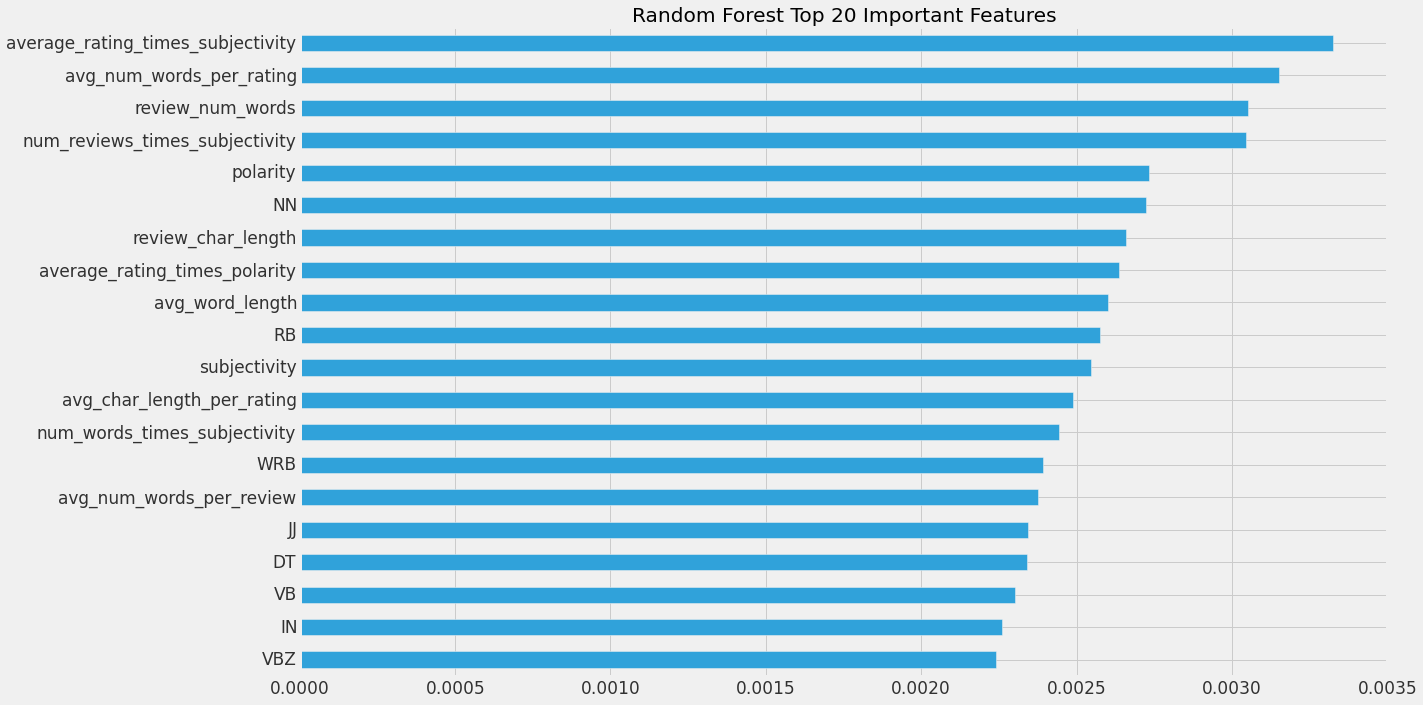

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, grid_search

#Fit a random forest model with 500 trees ti identify feature importance
est_rfc = RandomForestClassifier(n_estimators=500).fit(df_train.values, df_train_y.failed_ind.values)

# Visualize feature importance
plt.style.use('fivethirtyeight')
ax = pd.DataFrame({'importance' : est_rfc.feature_importances_},
             index = df_train.columns).sort_values('importance',
                                                   ascending=True).tail(20).plot(kind = 'barh', legend=False,
                                                                                 figsize=(20,10),
                                                                                 fontsize=17,
                                                                                 title = 'Random Forest Top 20 Important Features');

ax.tick_params(axis='x', colors='#303030')
ax.tick_params(axis='y', colors='#303030')
ax.xaxis.label.set_color('#303030')

plt.tight_layout()
plt.savefig(path + 'random_forest_var_imp_with_lr_vars.png') 

In [23]:
#Create a list of feautres in order of importance
rfc_var_imp = pd.DataFrame({'importance' : est_rfc.feature_importances_}, 
             index = df_train.columns).sort_values('importance', ascending=False).index

#Sort the data features in order of feature importance
%time df_train = df_train[rfc_var_imp]
%time df_test = df_test[rfc_var_imp]

Wall time: 593 ms
Wall time: 4min 9s


In [24]:
# Random Forest Feature Selection
# Create expanding loop capturing 2 additional features each loop and 
# calculate the cross-validation score per grouping of features
i=2 #Start with the first two most important variables
ls_i=[]
ls_mean=[]
ls_std = []

while i < 200: #Don't consider more than the top 200 features
    
    rf2_scores = cross_validation.cross_val_score(est_rfc, 
          df_train.iloc[:,0:i].values, 
          temp,
          cv=3, 
          scoring="f1", 
          verbose=0)
    
    ls_i.append(i)
    ls_mean.append(np.mean(rf2_scores))
    ls_std.append(np.std(rf2_scores))
    
    i = i + 2


df_var_selection_lr = pd.DataFrame({'num_vars':ls_i, 'mean':ls_mean, 'std':ls_std})
df_var_selection_lr = df_var_selection_lr.sort_values('mean', ascending=False)
top_num_features = int(df_var_selection_lr.iloc[0][1])
print "Top # of features", top_num_features

Top # of features 166


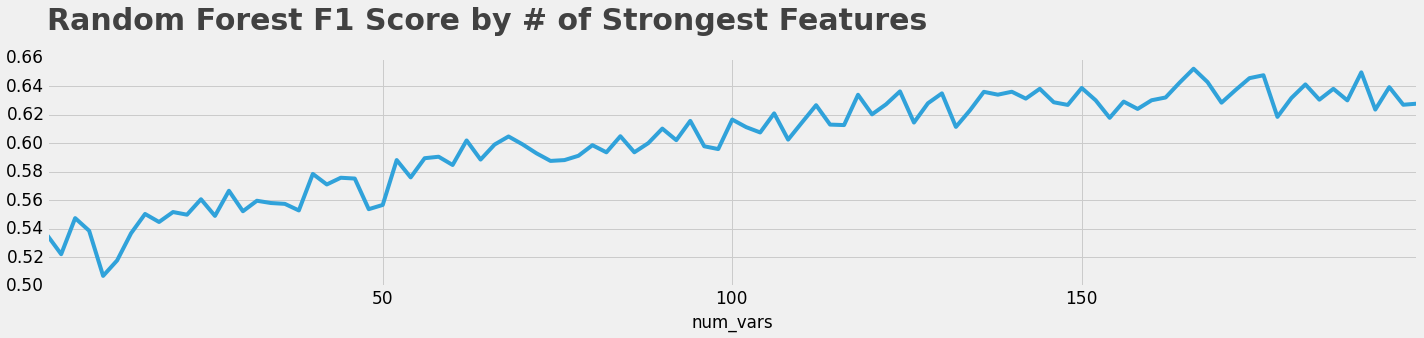

In [25]:
#Visualize the F1 score for every additional two variables added to identify the best CV score
plt.style.use('fivethirtyeight')
df_var_selection_lr.drop('std', axis=1).set_index('num_vars').sort_index().plot(fontsize=17, figsize=(20,5), legend=False);

plt.title('Random Forest F1 Score by # of Strongest Features', 
          loc='left', y=1.1, fontsize = 30, fontweight="bold", color='#404040');

ax.tick_params(axis='x', colors='#303030')
ax.tick_params(axis='y', colors='#303030')
ax.xaxis.label.set_color('#303030')

plt.tight_layout()
plt.savefig(path + 'random_forest_performance_top_200.png')

In [26]:
#View the logs to idenify the best F1 Score from CV results
df_var_selection_lr.head(5)

,mean,num_vars,std
82,0.652136,166,0.026462
94,0.649596,190,0.028229
87,0.647568,176,0.022730
86,0.645541,174,0.036770
83,0.642795,168,0.031505


In [28]:
#Fit the final model with the best features and hyper parameters.
est_rfc2 = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2).fit(df_train.iloc[:,0:top_num_features].values, 
                                                                          df_train_y.failed_ind.values)

rf_predictions = pd.DataFrame({'NathanG':est_rfc2.predict(df_test.iloc[:,0:top_num_features].values)})

#Write predictions for submission
rf_predictions.to_csv(path + 'rf_predictions.csv', index=False) 